# Build Correlation Plots
Runbook for making correlation plots.

Focus mainly on generating univariate correlation plots.

- Created: 06/19/2021
- Author:  Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, ttest_ind
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })

plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (4.5, 4.5),
                    'facecolor'  : 'white',
                    'dpi'        : 100
                    })

plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

In [5]:
path = 'output/correlation_data.csv'
df = pd.read_csv(path)
df = df[df['cellid'] != 9]

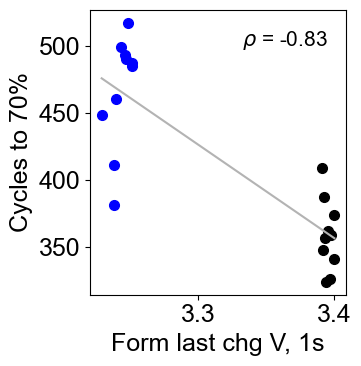

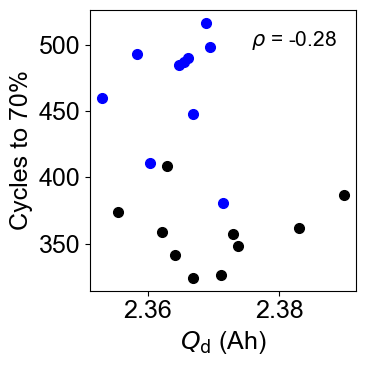

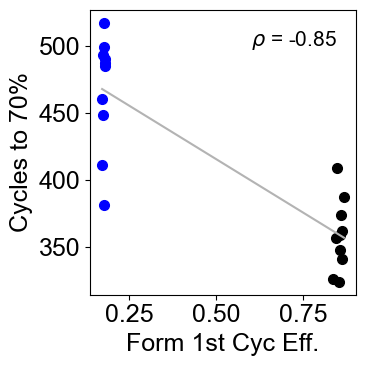

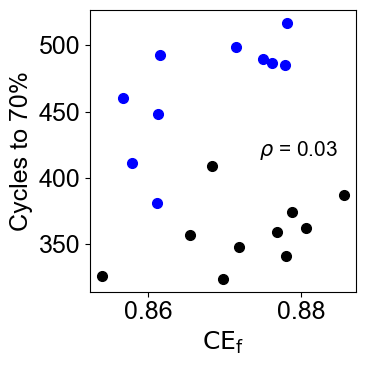

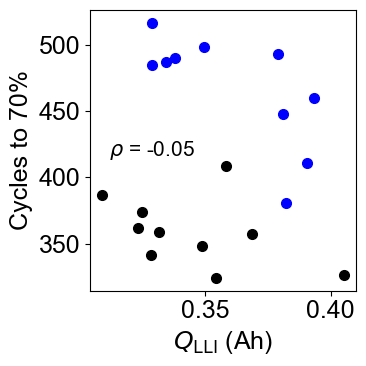

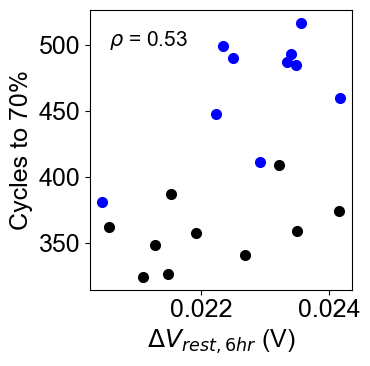

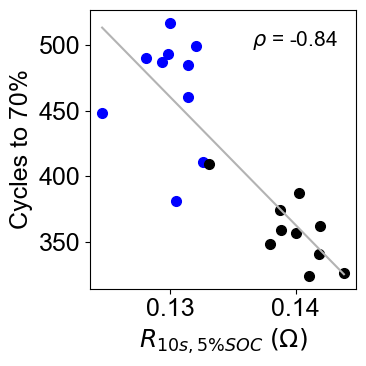

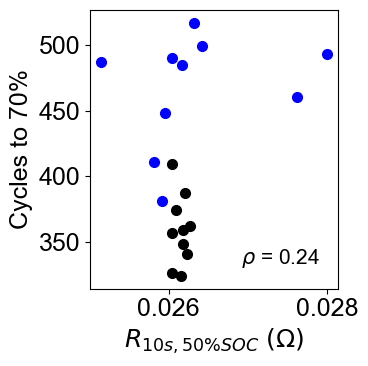

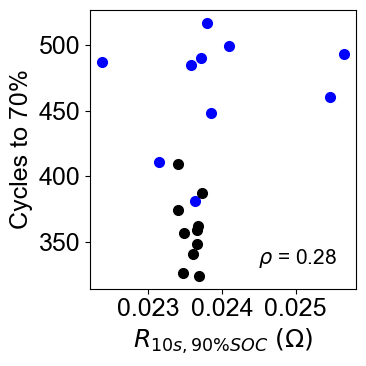

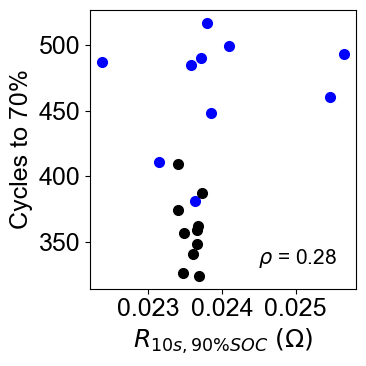

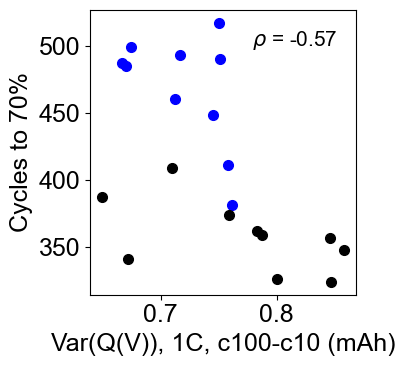

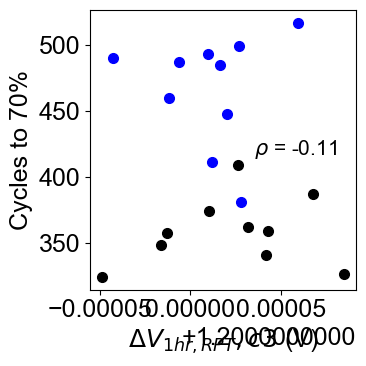

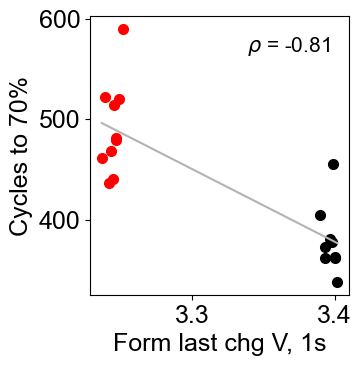

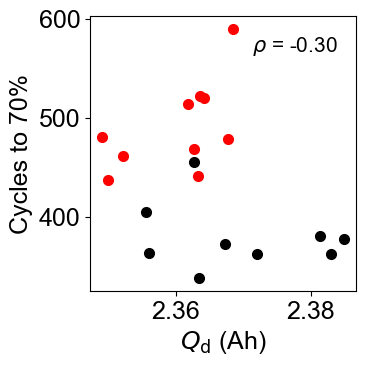

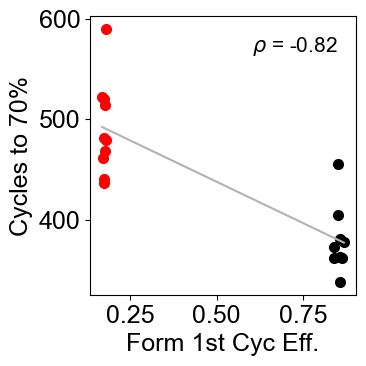

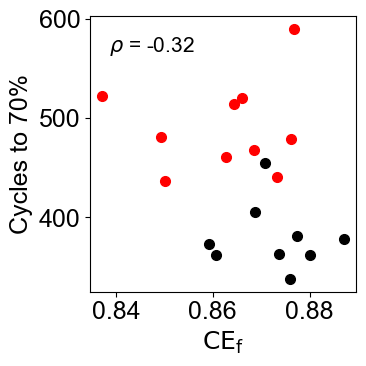

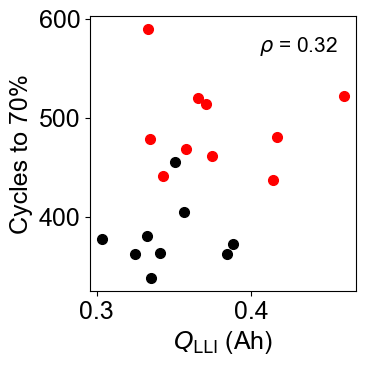

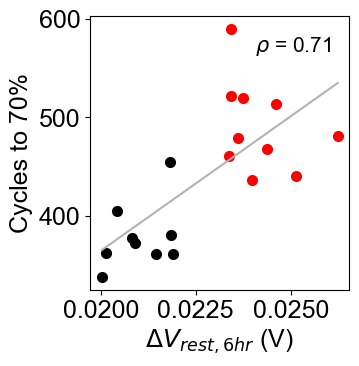

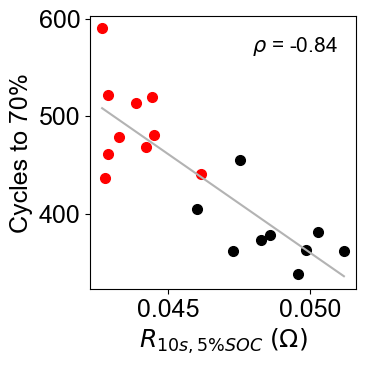

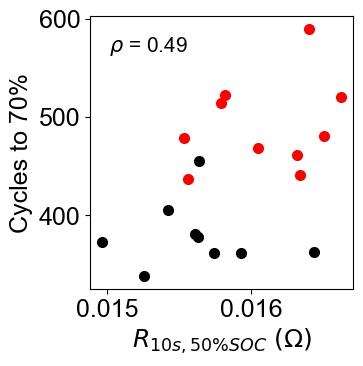

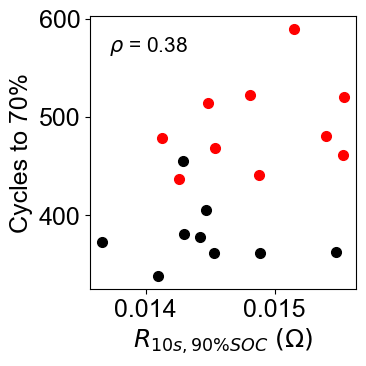

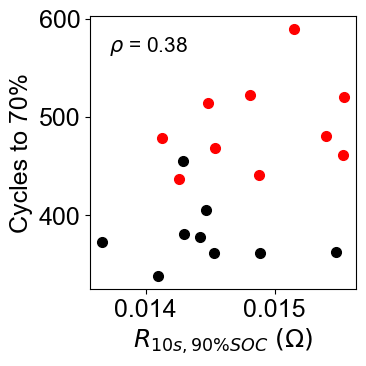

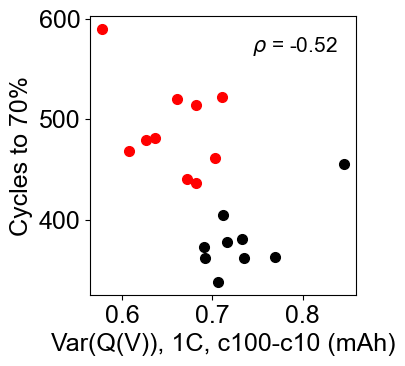

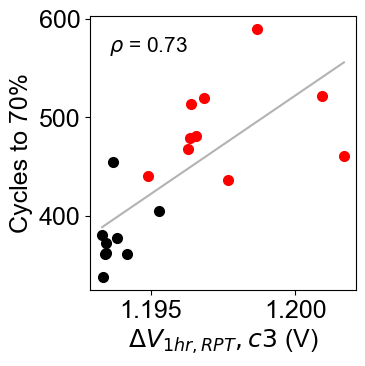

In [6]:
label_registry = get_label_registry()


df = pd.read_csv(path)
df = df[df['cellid'] != 9]

df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan

df['var_q_1c_c100_c10_mah'] = df['var_q_1c_c100_c10_ah'] * 1000

df_rt = df[df['is_room_temp_aging'] == 1]
df_ht = df[df['is_room_temp_aging'] == 0]

xvar_array = ['form_last_charge_voltage_after_1s',
              'form_final_discharge_capacity_ah',
              'form_first_cycle_efficiency',
              'form_coulombic_efficiency',
              'form_qc_minus_qd_ah',
              'form_6hr_rest_delta_voltage_v',
              'dcr_10s_5_soc_at_c3', 
              'dcr_10s_50_soc_at_c3', 
              'dcr_10s_90_soc_at_c3',
              'dcr_10s_90_soc_at_c3',
              'var_q_1c_c100_c10_mah',
              'rpt_c3_delta_v']

# cyc_idx_rpt_arr = [3, 56, 159, 262, 365]
# [xvar_array.append(f'var_q_c20_c{x}_c3_ah') for x in cyc_idx_rpt_arr[1::] ]
# [xvar_array.append(f'esoh_c{x}_Cn') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_CnCp') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_x0') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_x100') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_y0') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_y100') for x in cyc_idx_rpt_arr ]
# [xvar_array.append(f'esoh_c{x}_neg_excess') for x in cyc_idx_rpt_arr ]

# Also try: 'thickness_mm'
yvar = 'cycles_to_70_pct'

df_array = [df_rt, df_ht]
color_fast_array = [COLOR_FAST_RT, COLOR_FAST_HT]

# Loop over temperatures
for df, color_fast in zip(df_array, color_fast_array): 
    
    # Loop over x-variables
    for xvar in xvar_array:

        model = LinearRegression()

        x = df[xvar].values
        y = df[yvar].values
        idx_to_keep = ~np.isnan(x)
        x = x[idx_to_keep]
        y = y[idx_to_keep]

        corr, _ = pearsonr(x, y)
        model.fit(x.reshape(-1, 1), y)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))
        
        idx_base = np.where(df['is_baseline_formation'] == True)[0]
        idx_fast = np.where(df['is_baseline_formation'] == False)[0]

        plt.figure(figsize=(4, 4))

        plt.plot(df[xvar].iloc[idx_fast], df[yvar].iloc[idx_fast], 
                 linestyle='None', marker='o', markersize=7,
                 color=color_fast, label='')

        plt.plot(df[xvar].iloc[idx_base], df[yvar].iloc[idx_base], 
                 linestyle='None', marker='o', markersize=7,
                 color=COLOR_BASE, label='')

        if corr**2 > 0.5:
            plt.plot(x_fit, y_fit, color=COLOR_REF, label='')
            
        plt.plot(np.nan, np.nan, label=rf'$\rho$ = {corr:.2f}',
                         marker='None', linestyle='None')

        leg = plt.legend(frameon=False,
                             handletextpad=0, handlelength=0, fontsize=15)

#         plt.xlim(label_registry[xvar][1])
        plt.xlim((None, None))
        plt.xlabel(label_registry[xvar][0])
        plt.ylabel(label_registry[yvar][0])


## Make Correlation Plots

In [7]:
import seaborn as sns

In [8]:
df_rt = df[df['is_room_temp_aging'] == True]
df_ht = df[df['is_room_temp_aging'] == False]

columns_to_drop = ['cellid', 'is_baseline_formation', 'is_room_temp_aging']

df_rt = df_rt.drop(columns=columns_to_drop)
df_ht = df_ht.drop(columns=columns_to_drop)

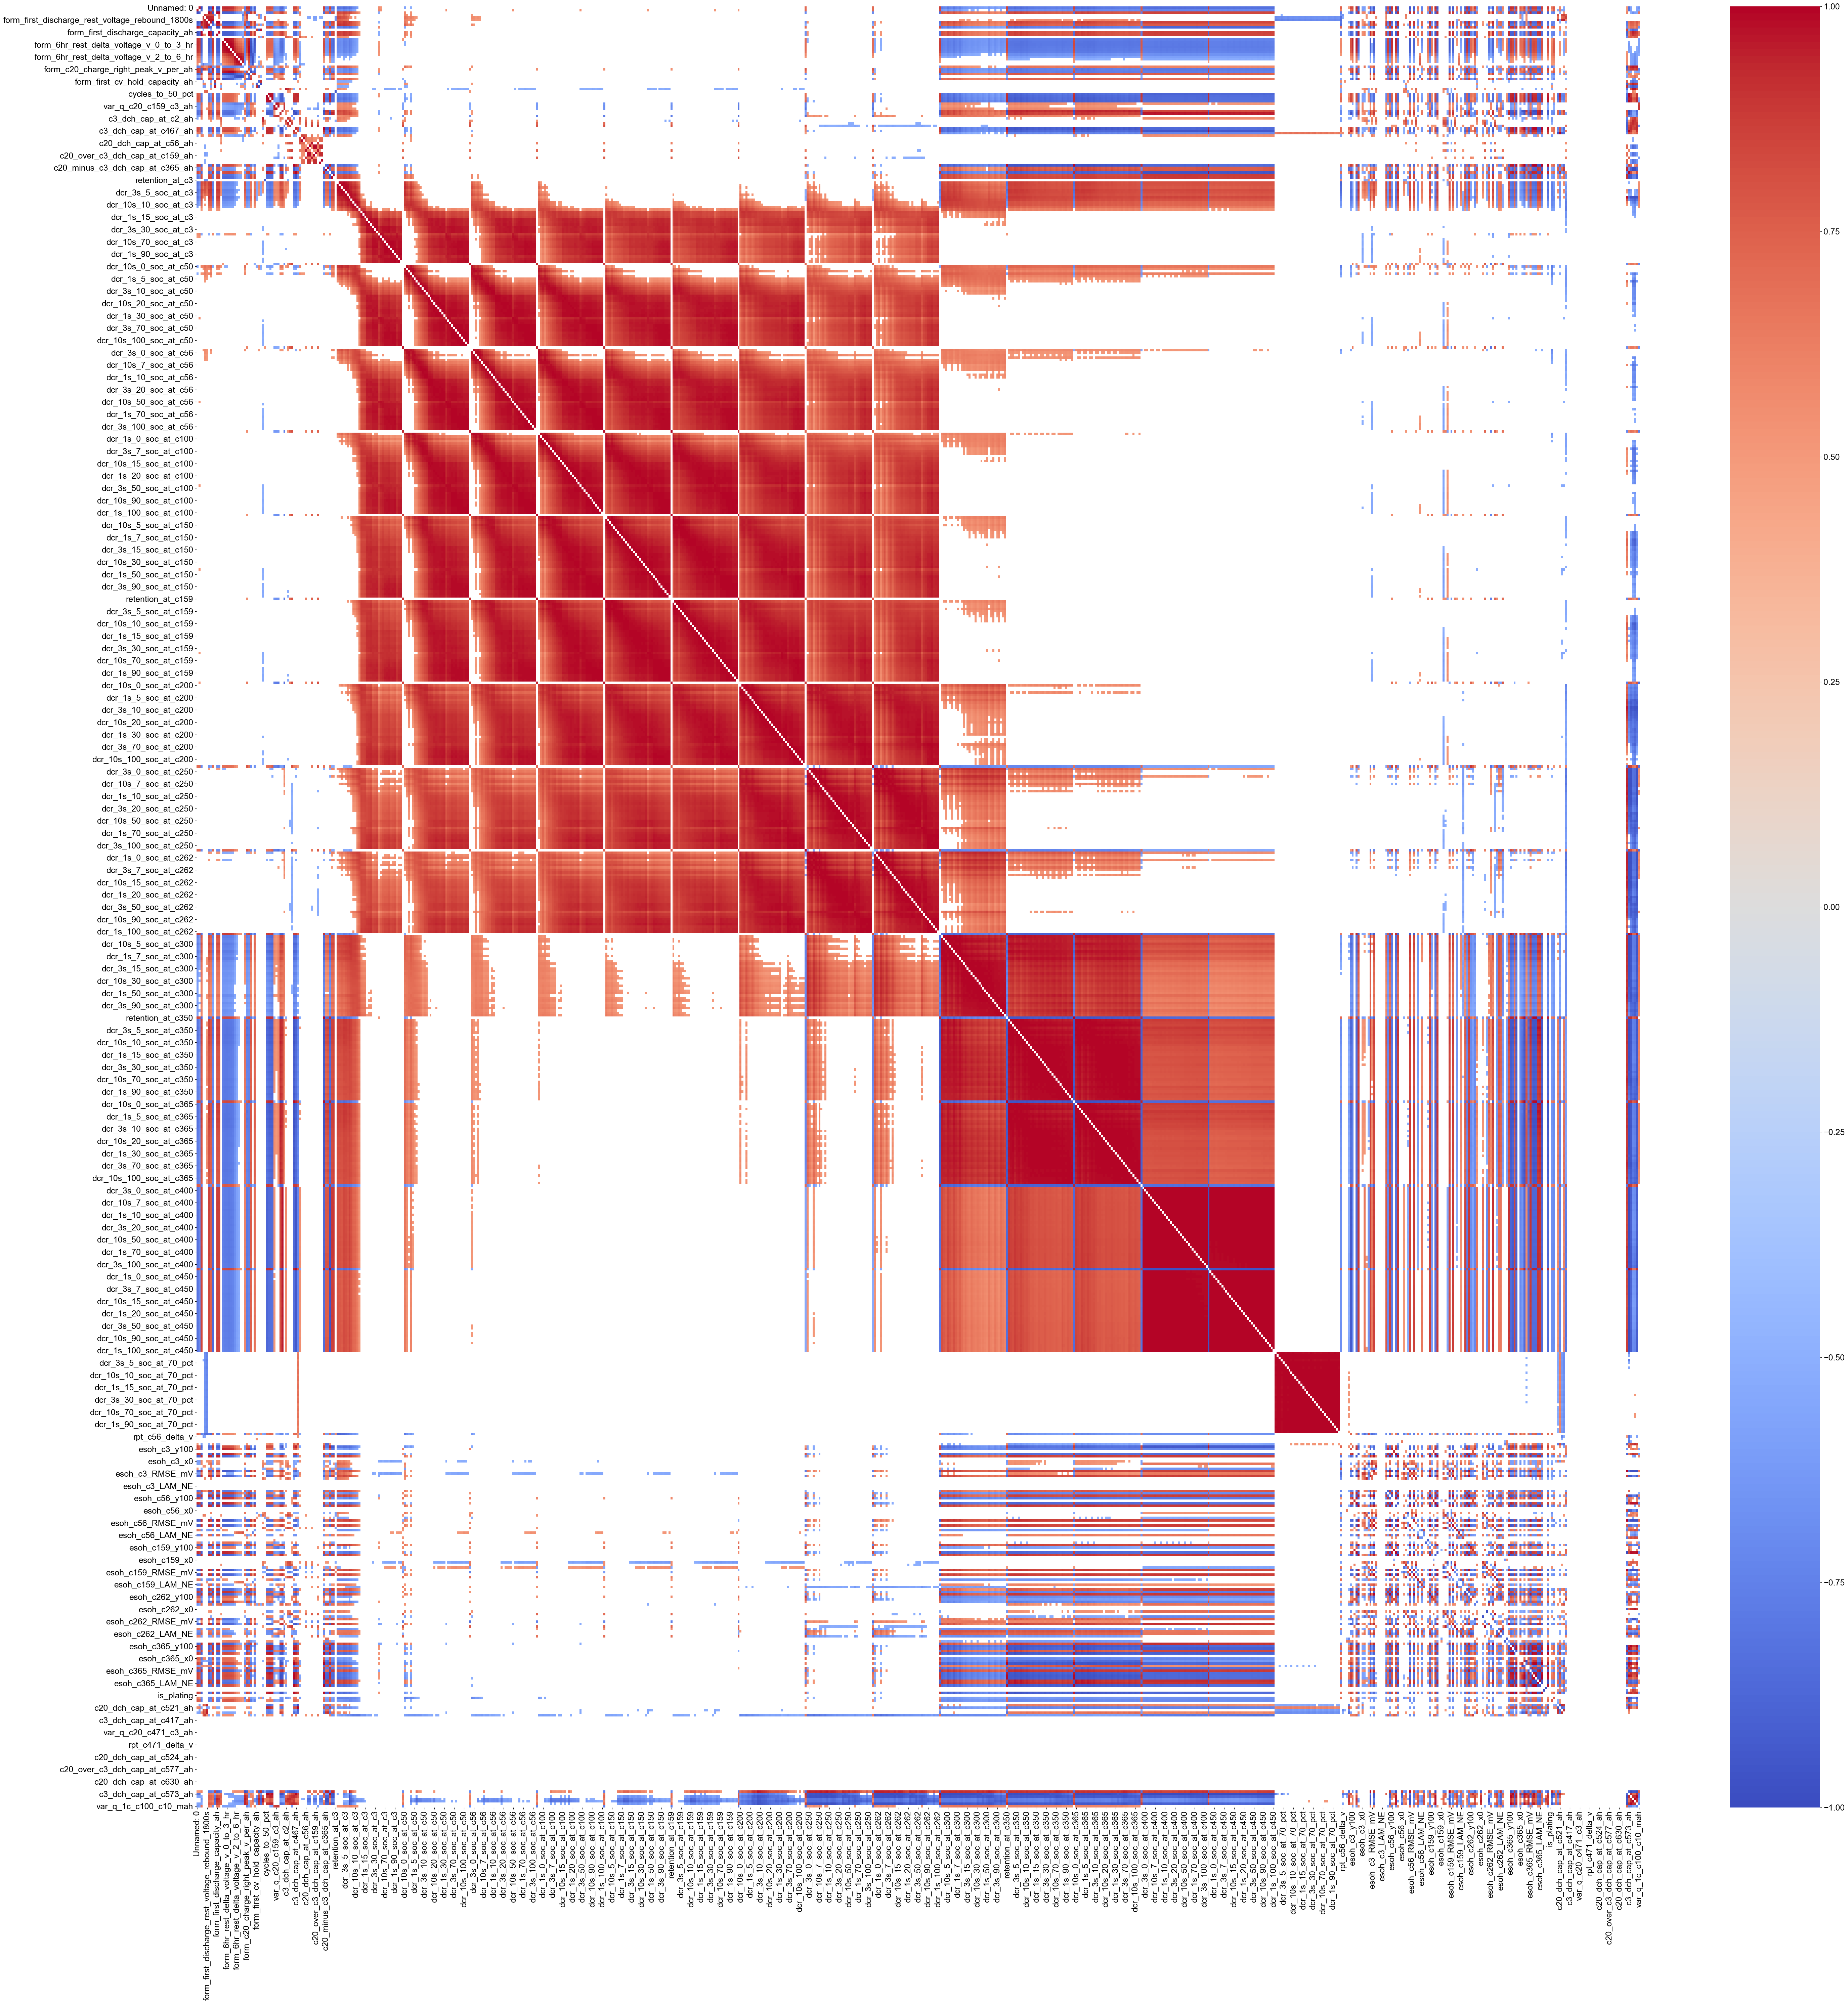

In [9]:
# High temperature

dfCorr = df_ht.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
fig = plt.figure(figsize=(60,60))
sns.heatmap(filteredDf, annot=False, cmap="coolwarm")
plt.show()